# Project 2
group 15
Member：
HaoyeChen
FangzhouLiu
XiuruLi
YukunSu
### Image reproduction
Picture source from https://ec.europa.eu/eurostat/statistics-explained/index.php?title=File:Causes_of_death_among_women_aged_65_years_or_over,_EU,_2012%E2%80%9322_(index_based_on_standardised_death_rate_per_100_000_inhabitants,_2012_%3D_100)_Health2025.png

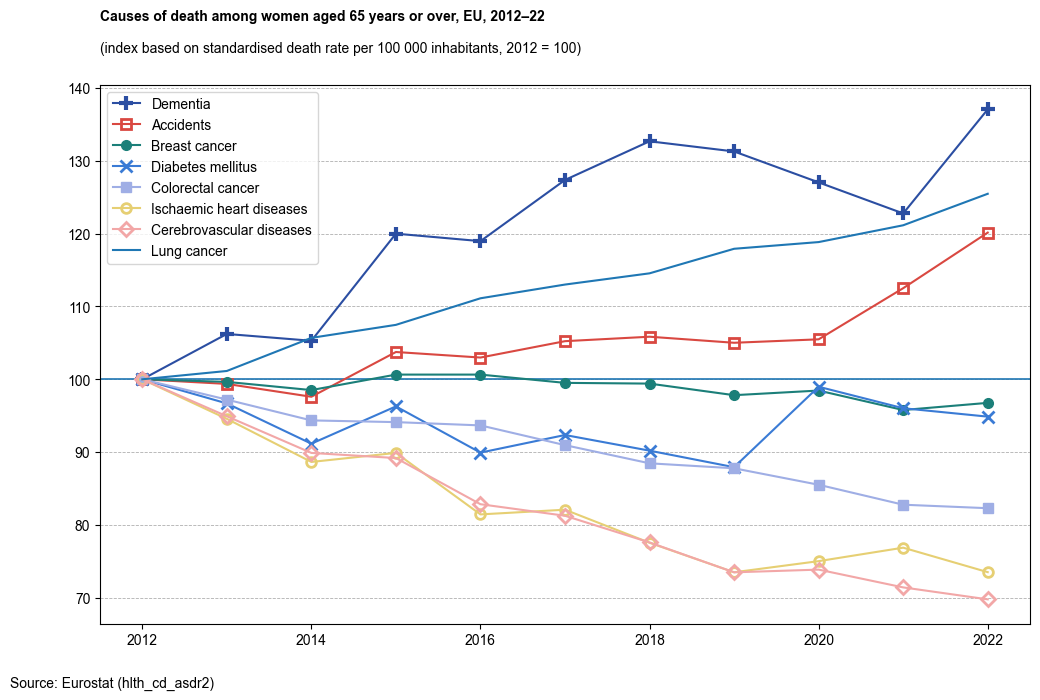

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase

# Global plotting style
plt.rcParams['font.family'] = ['Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# Custom legend handler for lung cancer
class HandlerLungCancer(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        line, fill, outline = orig_handle
        yc = y0 + height / 2
        x_left = x0
        x_right = x0 + width
        x_mid = x0 + width * 0.55

        l = Line2D([x_left, x_right], [yc, yc], color=line.get_color(), linewidth=line.get_linewidth())
        l.set_transform(trans)

        f = Line2D([x_mid], [yc], linestyle='None', marker=fill.get_marker(),
                   markersize=fill.get_markersize(), markerfacecolor=fill.get_markerfacecolor(),
                   markeredgecolor=fill.get_markeredgecolor())
        f.set_transform(trans)

        o = Line2D([x_mid], [yc], linestyle='None', marker=outline.get_marker(),
                   markersize=outline.get_markersize(), markerfacecolor='none',
                   markeredgecolor=outline.get_markeredgecolor(), markeredgewidth=outline.get_markeredgewidth())
        o.set_transform(trans)
        return [l, f, o]

# Load and clean data
csv_path = 'hlth_cd_asdr2__custom_19310484_linear.csv'
df = pd.read_csv(csv_path)
df['TIME_PERIOD'] = pd.to_numeric(df['TIME_PERIOD'], errors='coerce')
df = df.dropna(subset=['TIME_PERIOD'])
df['TIME_PERIOD'] = df['TIME_PERIOD'].astype(int)

target_geo = "European Union - 27 countries (from 2020)"
target_sex = "Females"
target_age = "65 years or over"
filtered_df = df[(df['geo'] == target_geo) &
                 (df['sex'] == target_sex) &
                 (df['age'] == target_age)].copy()

# ICD-10 cause mapping
icd_mapping = {
    'Dementia': ['dementia'],
    'Lung cancer': ['trachea, bronchus and lung'],
    'Accidents': ['accidents'],
    'Breast cancer': ['breast'],
    'Diabetes mellitus': ['diabetes mellitus'],
    'Colorectal cancer': ['colon', 'rectum'],
    'Ischaemic heart diseases': ['ischaemic heart'],
    'Cerebrovascular diseases': ['cerebrovascular']
}

def map_icd_category(val):
    val_lower = str(val).lower()
    for label, keywords in icd_mapping.items():
        if all(k in val_lower for k in keywords): return label
    return None

# Prepare indexed time series (2012 = 100)
filtered_df['Cause_Label'] = filtered_df['icd10'].apply(map_icd_category)
final_df = filtered_df.dropna(subset=['Cause_Label'])
pivot_df = final_df.pivot_table(index='TIME_PERIOD', columns='Cause_Label', values='OBS_VALUE')
indexed_df = pivot_df.div(pivot_df.loc[2012]) * 100

# Visual style settings
style_config = {
    'Dementia': {'color': '#2B4EA2', 'marker': '+', 'markersize': 10, 'markeredgewidth': 3},
    'Lung cancer': {'color': '#B38E00', 'marker': 'D', 'markersize': 7},
    'Accidents': {'color': '#D94841', 'marker': 's', 'markersize': 7, 'fillstyle': 'none', 'markeredgewidth': 2},
    'Breast cancer': {'color': '#1B7F79', 'marker': 'o', 'markersize': 7},
    'Diabetes mellitus': {'color': '#3A7BD5', 'marker': 'x', 'markersize': 8, 'markeredgewidth': 2},
    'Colorectal cancer': {'color': '#9FAEE5', 'marker': 's', 'markersize': 7},
    'Ischaemic heart diseases': {'color': '#E6CF73', 'marker': 'o', 'markersize': 7, 'fillstyle': 'none', 'markeredgewidth': 2},
    'Cerebrovascular diseases': {'color': '#F2A7A7', 'marker': 'D', 'markersize': 7, 'fillstyle': 'none', 'markeredgewidth': 2}
}

# Figure setup
fig, ax = plt.subplots(figsize=(12, 7))

# Baseline and grid
ax.grid(axis='y', linestyle='--', linewidth=0.6, zorder=0)
ax.axhline(y=100, linewidth=1.2, zorder=2)

# Plot causes (lung cancer highlighted separately)
for label, style in style_config.items():
    if label != 'Lung cancer' and label in indexed_df.columns:
        ax.plot(indexed_df.index, indexed_df[label], label=label, **style)

# Lung cancer emphasis
if 'Lung cancer' in indexed_df.columns:
    ax.plot(indexed_df.index, indexed_df['Lung cancer'], label='Lung cancer')

# Titles
ax.text(0, 1.12,
        'Causes of death among women aged 65 years or over, EU, 2012–22',
        transform=ax.transAxes, fontweight='bold')
ax.text(0, 1.06,
        '(index based on standardised death rate per 100 000 inhabitants, 2012 = 100)',
        transform=ax.transAxes)

# Legend and source
ax.legend()
fig.text(0.05, 0.02, 'Source: Eurostat (hlth_cd_asdr2)')

plt.show()


In [5]:
import pandas as pd
from pyecharts.charts import Line
from pyecharts import options as opts

# Load, filter and index Eurostat data
def load_and_process_data(csv_path):
    df = pd.read_csv(csv_path)

    # Clean year column
    df['TIME_PERIOD'] = pd.to_numeric(df['TIME_PERIOD'], errors='coerce')
    df = df.dropna(subset=['TIME_PERIOD'])
    df['TIME_PERIOD'] = df['TIME_PERIOD'].astype(int)

    # Target population: EU women aged 65+
    target_geo = "European Union - 27 countries (from 2020)"
    target_sex = "Females"
    target_age = "65 years or over"

    mask = (
        (df['geo'] == target_geo) &
        (df['sex'] == target_sex) &
        (df['age'] == target_age)
    )
    df = df[mask].copy()

    # Map ICD-10 codes to cause categories
    icd_mapping = {
        'Dementia': ['dementia'],
        'Lung cancer': ['trachea', 'bronchus', 'lung'],
        'Accidents': ['accidents'],
        'Breast cancer': ['breast'],
        'Diabetes mellitus': ['diabetes mellitus'],
        'Colorectal cancer': ['colon', 'rectum'],
        'Ischaemic heart diseases': ['ischaemic heart'],
        'Cerebrovascular diseases': ['cerebrovascular']
    }

    def map_name(text):
        text = str(text).lower()
        for k, v in icd_mapping.items():
            if all(x in text for x in v):
                return k
        return None

    df['Series_Name'] = df['icd10'].apply(map_name)
    df = df.dropna(subset=['Series_Name'])

    # Reshape and index values (base year = 100)
    pivot = df.pivot_table(
        index='TIME_PERIOD',
        columns='Series_Name',
        values='OBS_VALUE'
    )

    base_year = 2012 if 2012 in pivot.index else pivot.index.min()
    indexed = pivot.div(pivot.loc[base_year]) * 100
    return indexed


# Visual style configuration
STYLE_CONFIG = {
    'Dementia':                 {'color': '#2B4EA2', 'symbol': 'diamond',  'symbol_size': 10},
    'Lung cancer':              {'color': '#B38E00', 'symbol': 'triangle', 'symbol_size': 14},
    'Accidents':                {'color': '#D94841', 'symbol': 'rect',     'symbol_size': 8},
    'Breast cancer':            {'color': '#1B7F79', 'symbol': 'circle',   'symbol_size': 8},
    'Diabetes mellitus':        {'color': '#3A7BD5', 'symbol': 'circle',   'symbol_size': 8},
    'Colorectal cancer':        {'color': '#9FAEE5', 'symbol': 'rect',     'symbol_size': 8},
    'Ischaemic heart diseases': {'color': '#E6CF73', 'symbol': 'circle',   'symbol_size': 8},
    'Cerebrovascular diseases': {'color': '#F2A7A7', 'symbol': 'diamond',  'symbol_size': 8}
}

# Series display order
SERIES_ORDER = list(STYLE_CONFIG.keys())


# Create interactive time-series chart
def create_interactive_chart(df, output_file="eurostat_interactive.html"):
    years = [str(y) for y in df.index.tolist()]

    # Y-axis range
    y_min = max(0, df.min().min() - 15)
    y_max = df.max().max() + 15

    # Chart initialization
    c = Line(init_opts=opts.InitOpts(
        width="100%",
        height="700px",
        page_title="Eurostat Interactive",
        theme="white",
        animation_opts=opts.AnimationOpts(
            animation_duration=10000,
            animation_easing="cubicOut"
        )
    ))

    c.add_xaxis(years)

    # Add series
    for name in SERIES_ORDER:
        if name not in df.columns:
            continue

        style = STYLE_CONFIG[name]
        line_width = 4 if name == "Lung cancer" else 2

        c.add_yaxis(
            series_name=name,
            y_axis=df[name].round(2).tolist(),
            is_symbol_show=True,
            symbol=style['symbol'],
            symbol_size=style['symbol_size'],
            linestyle_opts=opts.LineStyleOpts(
                width=line_width,
                color=style['color']
            ),
            itemstyle_opts=opts.ItemStyleOpts(
                color=style['color'],
                border_color=style['color'],
                border_width=2
            ),
            label_opts=opts.LabelOpts(is_show=False)
        )

        # Animation and emphasis
        c.options["series"][-1].update({
            "animationDelay": lambda i: i * 80,
            "endLabel": {
                "show": "auto",
                "formatter": f"{name}: " + "{@[1]}",
                "fontSize": 12,
                "color": style["color"],
                "padding": [2, 4],
                "backgroundColor": "rgba(255,255,255,0.85)"
            },
            "labelLayout": {"moveOverlap": "shiftY"},
            "emphasis": {
                "focus": "series",
                "lineStyle": {"width": line_width + 3}
            }
        })

    # Global chart options
    c.set_global_opts(
        title_opts=opts.TitleOpts(
            title="Causes of death among women aged 65 years or over, EU, 2012–22",
            subtitle="Interactive chart — Please hover the chart for more details",
            pos_left="center",
            subtitle_textstyle_opts=opts.TextStyleOpts(
                font_size=14,
                font_weight="bold",
                color="#C00000"
            )
        ),
        tooltip_opts=opts.TooltipOpts(trigger="axis"),
        xaxis_opts=opts.AxisOpts(type_="category", boundary_gap=False),
        yaxis_opts=opts.AxisOpts(
            type_="value",
            min_=round(y_min),
            max_=round(y_max),
            name="Standardised death rate per 100 000 inhabitants\n(Index, 2012 = 100)"
        )
    )

    # Layout and baseline
    c.options["grid"] = [{"right": "20%", "bottom": "10%", "containLabel": True}]
    c.options["series"][0]["markLine"] = {
        "silent": True,
        "symbol": "none",
        "lineStyle": {"color": "black", "width": 1.5},
        "data": [{"yAxis": 100}]
    }

    # Render output
    c.render(output_file)
    print(f"Output: {output_file}")


# Run pipeline
if __name__ == "__main__":
    data = load_and_process_data("hlth_cd_asdr2__custom_19310484_linear.csv")
    create_interactive_chart(data)


Output: eurostat_interactive.html
